In [1]:
import sys
import numpy as np
import gzip
import pickle
from collections import defaultdict
import copy

def load(networkx_path):
    with gzip.open(networkx_path, 'rb') as f:
        G = pickle.load(f)
    return G

In [2]:
G = load('../graph_mf_grc_binary_210519.gz')

Test NetworkX graph_mf_grc_binary_210519.gz by running a share counting analysis code.

This code was adapted from https://github.com/htem/cb2_project_analysis/blob/main/analysis/mf_grc_analysis/share_distribution/distribution_123share_bouton_210516.ipynb

Note that the results and plots are slightly different because we used a more recent version of the proofreadings.

In [9]:
# Define an ROI box (in nm). We do this for 2 reasons:
# 1. Specify where GrCs and MFs were densely proofread.
# 2. Exclude counting GrCs near the edges of the EM volume.
#    This is because GrCs near the edges are missing GrC partners that we cannot observe.
# Note that we use all neurons for counting, but we only count sharing statistics of the GrCs within the ROI.
# Also note there is no restriction for the Y axis.

# For Z, we count GrCs of the inner 10um out of the available ~50um.
z_min = 19800
z_max = 29800

# In X dimension, GrCs are fully reconstructed and proofread from 90k to 150k
# MFs are from 70k to 160k. Here we conservatively use an even smaller ROI:
x_min = 105*1000*4
x_max = 135*1000*4

In [4]:
# Get grc and mf lists
all_grcs = []
all_boutons = []
for n in G.nodes():
    if G.nodes[n]['cell_type'] == 'grc':
        all_grcs.append(n)
    else:
        all_boutons.append(n)

In [6]:
# Quick check by printing a random GrC and its connected MFs
# For syntax, see: https://networkx.org/documentation/stable/reference/classes/digraph.html
for n in all_grcs:
    print(G.nodes[n])
    print(list(G.predecessors(n)))
    break

{'xyz': (344532, 408012, 5640), 'cell_type': 'grc'}
['mf_0__0', 'mf_181__1', 'mf_52__2', 'mf_63__3']


In [7]:
n_randoms = 5
replication_hist2 = defaultdict(int)
grc_ids = set()
mf_ids = set()
replicated_2shares = defaultdict(int)

def get_prob(in_graph, unique_count=False, return_counted=False):
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    n = 0
    counted_grcs = 0
    for grc_i_id in all_grcs:
        n += 1
        grc_i = in_graph.nodes[grc_i_id]
        x, y, z = grc_i['xyz']
        if x < x_min or x > x_max:
            continue
        if z < z_min or z > z_max:
            continue
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        rosettes_i = set(list(in_graph.predecessors(grc_i_id)))
        for r in rosettes_i:
            mf_ids.add(r)
        for grc_j_id in all_grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.nodes[grc_j_id]
            x, y, z = grc_j['xyz']
            common_rosettes = set(list(in_graph.predecessors(grc_j_id)))
            common_rosettes = common_rosettes & rosettes_i
            hist[len(common_rosettes)] += 1
            if len(common_rosettes) == 2:
                replication_hist2[grc_i_id] += 1
                common_rosettes = tuple(sorted(list(common_rosettes)))
                replicated_2shares[common_rosettes] += 1
    for k in hist:
        # fix 0 data point for log plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, counted_grcs
    else:
        return hist

input_observed = copy.deepcopy(G)
hist_data, n_grcs = get_prob(input_observed, return_counted=True)

print(n_grcs)
print(hist_data)
print(len(mf_ids))

211
defaultdict(<class 'int'>, {0: 819377, 2: 897, 1: 13560, 3: 37, 4: 1})
282


Height: 4, Aspect: 2


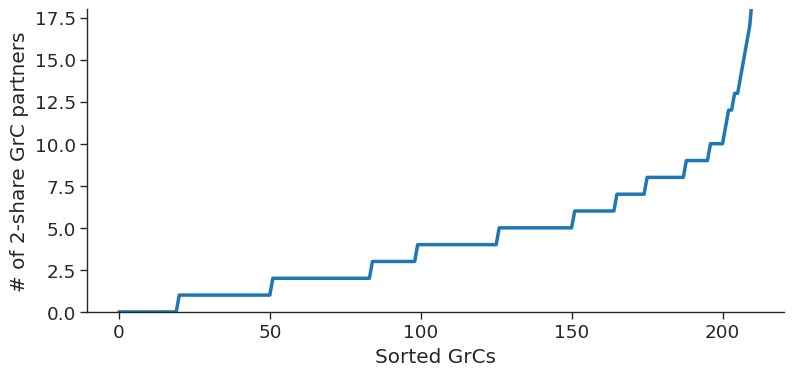

In [8]:
sys.path.insert(0, '../../analysis')
import my_plot
import importlib
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

script_n = 'analysis_grc_input_sharing'

replication_hist2_list = []
for grc in grc_ids:
    if grc in replication_hist2:
        replication_hist2_list.append((grc, replication_hist2[grc]))
    else:
        replication_hist2_list.append((grc, 0))
replication_hist2_list_sorted = sorted(replication_hist2_list, key=lambda x: x[1])

mpd = MyPlotData()
mpd_count = MyPlotData()
i = 0
for grc_id, count in replication_hist2_list_sorted:
    mpd_count.add_data_point(
        count=count,
        grc_id=grc_id,
        i=i,
        model='Observed',
    )
    i += 1

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='i',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    ylim=[0, 18],
    height=4,
    aspect=2,
    y_axis_label='# of 2-share GrC partners',
    x_axis_label='Sorted GrCs',
#     save_filename=f'{script_n}_line.svg',
    show=True,
    )
